## Simulación Paper Dripping Faucet

#### Introducción

La idea de este notebook es interpretar el paper [The Chaotic Dripping Faucet](https://nldlab.gatech.edu/w/images/f/f6/Royer_Caleb_PHYS6268_Royer_FinalPaper.pdf), explicando como un sistema de goteo dinámico se puede convertir en un sistema de goteo caótico. En este notebook se intentara el sistema de ecuaciones diferenciales que plantaron para resolver el problema y realizar algunas simulaciones.

#### Explicación del Experimento

El experimento consistió en en la creación de un experimento que consistía de un tanque de fluidos que tenia un regulador de flujo, de esta manera el liquido atraviesa una boquilla y poder simular un sistema de goteo, además se organiza un laser y un fotodiodo alineado perpendicularmente a la dirección de la caída de gotas para interceptarla, de esta manera se captura el tiempo entre la gotas.

Esta configuración inicial paso por diferentes cambios debido a que se tomaban periodos incorrectos en la caída o habían muchos problemas mecánicos, al final se implemento una bomba de aire que fue usado para que el agua corriera a traves de un tubo flexible de $5mm$ de diámetro. La bomba disponía de un regulador de flujo integrado, esto permitiría un ajuste directo del flujo. Pero no se indicaban las unidades de medición para la bomba por lo cual se realizo una regresión lineal para obtener una conversión de las unidades de bomba a unidades de SI. Este factor de conversión es $\frac{mL}{s} = 0.004563FRU$ donde FRU es la velocidad del flujo.

#### Planteamiento de la Ecuación Diferencial

Realizando un pequeño bosquejo de experimento 

<img src="../assets/imgs/experiment_img.jpg" label="img1" alt="Dripping Faucet Draw" width=550 style="display: block; margin: auto;">

podemos aproximar el problema como un sistema de masa-resorte-amortiguado, donde:

- La masa de la gota aumenta de manera constante conforme el agua fluye a través de la boquilla.
- La tensión superficial actúa como una fuerza restauradora similar a un resorte.
- La viscosidad del fluido genera una fuerza de amortiguamiento que actúa contra el movimiento de la gota.

también podemos observar tres fuerzas que están aplicando sobre la gota:
- **Fuerza Gravitacional** $(F_g = mg)$: A medida que la gota crece, su peso $mg$ tiende a hacerla caer.
- **Fuerza de tension superficial** $(F_{tensión}=-ky)$: Esta fuerza es proporcional al desplazamiento vertical de la gota $y$ desde la boquilla y opone a la gravedad, donde $K$ es la contante de resorte asociada a la tension superficial del agua.
- **Fuerza viscosa o de fricción** $(F_{fricción} = -bv)$: Esta fuerza es proporcional a la velocidad de la gota $v=\frac{dy}{dt}$ y se opone a su movimiento, donde $b$ es el coeficiente de fricción que depende de la viscosidad del agua.

Aplicamos la segunda ley de Newton al sistema de la gota obteniendo
$$ma = F_g + F_{tensión} +F_{fricción}$$

donde $a = \frac{d^2y}{dt^2}$ es la aceleración de la gota, $m$ es la masa de la gota.

Sustituyendo las fuerzas, obtenemos:
$$m\frac{d^2y}{dt^2} = mg-ky-b\frac{dy}{dt}$$

Así tenemos la ecuación diferencial principal que describe el movimiento de la gota.

Como a medida que el agua fluye desde la boquilla hacia la gota, la masa $m$
de la gota no es constante, sino que aumenta con el tiempo. Suponemos que la tasa de cambio de la masa es proporcional al flujo de agua a través de la boquilla:
$$\frac{dm}{dt} = flow_rate$$

Con la ecuación para la masa variable, podemos reescribir la ecuación diferencial tomando en cuenta que la masa aumenta con el tiempo. Esto implica que la ecuación de movimiento también depende de la masa variable $m(t)$ y se obtiene

$$\frac{d(mv)}{dt} = mg-ky-bv$$

Expandiendo el lado izquierdo, tenemos:
$$m\frac{dv}{dt} + v\frac{dm}{dt} = mg-ky-bv$$

Dado que la masa $m$ esta aumentado con el tiempo debido al flujo de agua, esta es la ecuación diferencial completa que modela el crecimiento y la caída de la gota.

Pero en este paper al final hacen uso de un modelo mejorado por Kiyono y Fuchikami que es
$$m\frac{dz}{dt} + (\frac{dz}{dt} - v_0)\frac{dm}{dt} = mg-kz-\gamma\frac{dz}{dt}$$
donde:
- $z$ es la altura desde la boquilla.
- $\gamma$ es el coeficiente de amortiguación viscoso.
- $v_0$ es la velocidad inicial de entrada del agua.
  
y se tiene en cuenta la ecuación $k(m)$ que describe como la constante de resorte,o fuerza de tensión superficial varía con la masa de la gota de agua a medida que se forma y esta dada por
$$\begin{equation*} k(m) =
    \left \{
        \begin{aligned}
            -11.4m +52.5 & \text{ ,si } m<4.61 \\
            0 & \text{ ,si } m \geq 4.61
        \end{aligned}
    \right.
\end{equation*}$$

Cuando $z = z_{crit}$, que es el punto de ruptura de la gota, luego $z =z_0$ y $\frac{dz}{dt} = 0$ 

#### Simulación del sistema

Para la simulación del sistema se usara la librería **scipy** que nos permite solucionar sistemas de ecuaciones diferenciales a traves de integrales pueden ver la documentación [aquí](https://docs.scipy.org/doc/scipy/reference/integrate.html).

In [38]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define K(m) como una función por tramos
def K_m(m):
    if m < 4.61:
        return -11.4 * m + 52.5
    else:
        return 0
    
# Define la velocidad inicial del agua en la boquilla
def V_0(flow_rate, a):
    return flow_rate / (np.pi * a **2)

# Define el flujo de masa en función del flujo del agua
def dm_dt(flow_rate):
    # Convierte el flujo mL/s
    return flow_rate


# Define la ecuación diferencial del sistema
def dripping_faucet(t, y, flow_rate, g, gamma, z_crit, a, desprendimientos):

    z, dz_dt, m = y  # y contiene [z, dz/dt, m]
    
    if z >= z_crit and desprendimientos == [0]:
        z = 0
        dz_dt = 0
        desprendimientos[0] += 1
    
    # Tasa de cambio de la masa
    dm_dt_value = dm_dt(flow_rate)

    # Segunda derivada de z (aceleración de la gota)
    d2z_dt2 = (m * g - K_m(m) * z - gamma * dz_dt -
               (dz_dt-V_0(flow_rate, a)) * dm_dt_value) / m

    # Ecuaciones diferenciales
    return [dz_dt, d2z_dt2, dm_dt_value]

- **Simulación con 0.21 mL/s de flujo del agua**

In [39]:
# Parámetros del sistema
g = 9.81  # Aceleración debido a la gravedad (m/s^2)
a = 5  # Diámetro de la boquilla (mm) - convertido de mm a mL
gamma = 0.03  # Coeficiente de amortiguación del agua
flow_rate = 0.21  # Flujo de agua constante (mL/s)

z_crit = 1  # Altura en el que la gota se desprende de la boquilla

desprendimientos = [0]

# Condiciones iniciales para un flujo de agua igual a 0.210 ml/s
z0 = 0  # Altura inicial de la gota
dz0_dt = V_0(flow_rate, a)  # Velocidad inicial de la gota (mL/s)
m0 = 2.75  # Masa inicial de la gota

# Tiempo de simulación
t_span = (0, 10)  # Simular de 0 a 10 segundos
t_eval = np.linspace(0,10,200)  # Puntos de tiempo para la evaluación

# Resolver la ecuación diferencial con el evento
sol = solve_ivp(dripping_faucet, t_span, [z0, dz0_dt, m0], args=(flow_rate, g, gamma, z_crit, a, desprendimientos), t_eval=t_eval)

# Extraer los resultados de la simulación
z = sol.y[0]  # Altura de la gota
dz_dt = sol.y[1]  # Velocidad de la gota
m = sol.y[2]  # Masa de la gota

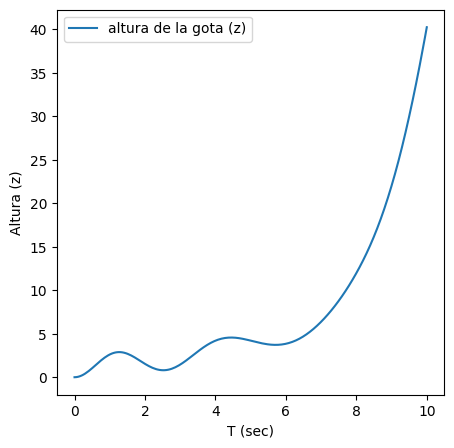

In [40]:
plt.figure(figsize=(5,5))
plt.plot(sol.t, z, label='altura de la gota (z)')
plt.xlabel('T (sec)')
plt.ylabel('Altura (z)')
plt.legend()
plt.show()

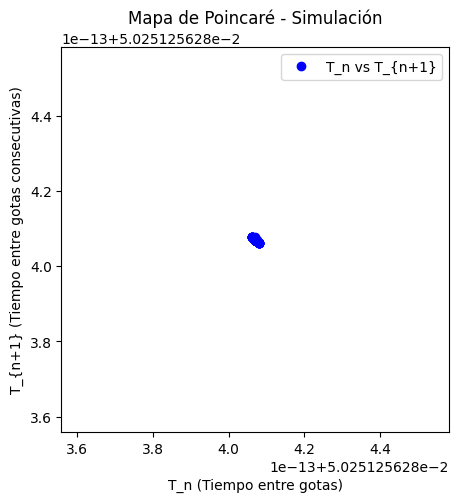

In [41]:
# Detección de eventos (momento en que la gota alcanza un umbral de caída)
threshold = 20  # ajusta según tu sistema
drop_events = sol.t[sol.y[0] < threshold]  # tiempos en los que la gota pasa el umbral

# Calculamos los periodos entre gotas consecutivas
periods = np.diff(drop_events)

# Graficar Mapa de Poincaré: T_n vs. T_{n+1}
plt.figure(figsize=(5, 5))
plt.plot(periods[:-1], periods[1:], 'bo', label='T_n vs T_{n+1}')
plt.xlabel('\nT_n (Tiempo entre gotas)')
plt.ylabel('T_{n+1} (Tiempo entre gotas consecutivas)')
plt.title('Mapa de Poincaré - Simulación')
plt.legend()
plt.show()

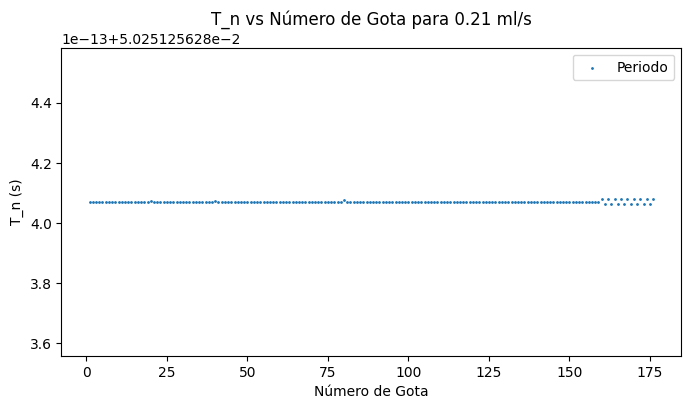

In [42]:
# Gráfica del periodo entre gotas vs el número de gota
plt.figure(figsize=(8, 4))
plt.scatter(np.arange(1, len(periods) + 1), periods, s=1, label='Periodo')
plt.xlabel('Número de Gota')
plt.ylabel('T_n (s)')
plt.title(f'T_n vs Número de Gota para {flow_rate} ml/s')
plt.legend()
plt.show()

- **Simulación con 0.374 mL/s de flujo de agua**

In [43]:
# Parámetros del sistema
flow_rate = 0.374  # Flujo de agua constante (mL/s)

desprendimientos = [0]

# Condiciones iniciales para un flujo de agua igual a 0.210 ml/s
z0 = 0  # Altura inicial de la gota
dz0_dt = V_0(flow_rate, a)  # Velocidad inicial de la gota (mL/s)
m0 = 2.75  # Masa inicial de la gota

# Tiempo de simulación
t_span = (0, 10)  # Simular de 0 a 10 segundos
t_eval = np.linspace(0,10,200)  # Puntos de tiempo para la evaluación
# Resolver la ecuación diferencial con el evento
sol = solve_ivp(dripping_faucet, t_span, [z0, dz0_dt, m0], args=(flow_rate, g, gamma, z_crit, a, desprendimientos), t_eval=t_eval)

# Extraer los resultados de la simulación
z = sol.y[0]  # Altura de la gota
dz_dt = sol.y[1]  # Velocidad de la gota
m = sol.y[2]  # Masa de la gota

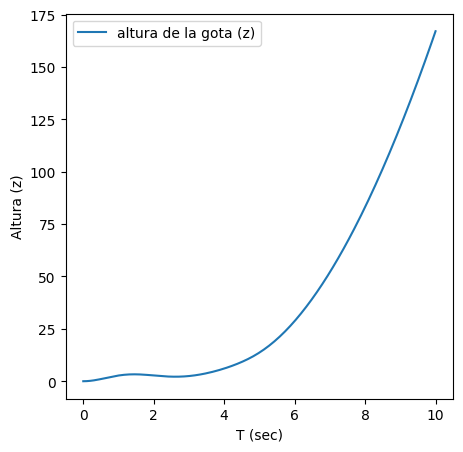

In [44]:
plt.figure(figsize=(5,5))
plt.plot(sol.t, z, label='altura de la gota (z)')
plt.xlabel('T (sec)')
plt.ylabel('Altura (z)')
plt.legend()
plt.show()

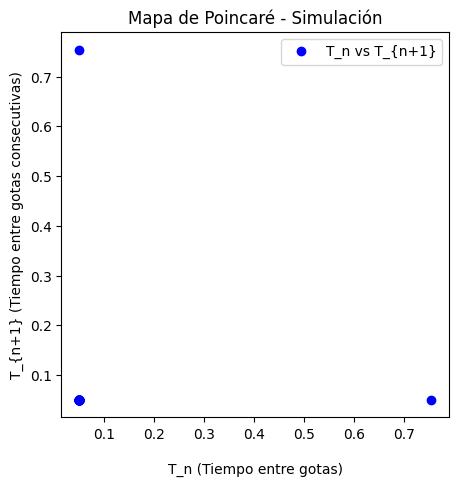

In [45]:
# Detección de eventos (momento en que la gota alcanza un umbral de caída)
threshold = 3  # ajusta según tu sistema
drop_events = sol.t[sol.y[0] < threshold]  # tiempos en los que la gota pasa el umbral

# Calculamos los periodos entre gotas consecutivas
periods = np.diff(drop_events)

# Graficar Mapa de Poincaré: T_n vs. T_{n+1}
plt.figure(figsize=(5, 5))
plt.plot(periods[:-1], periods[1:], 'bo', label='T_n vs T_{n+1}')
plt.xlabel('\nT_n (Tiempo entre gotas)')
plt.ylabel('T_{n+1} (Tiempo entre gotas consecutivas)')
plt.title('Mapa de Poincaré - Simulación')
plt.legend()
plt.show()

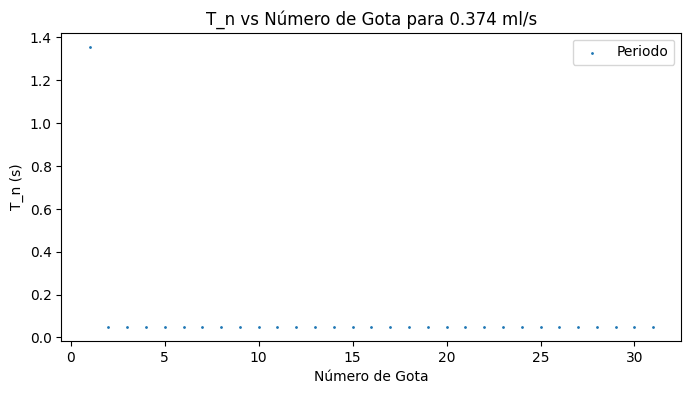

In [10]:
# Gráfica del periodo entre gotas vs el número de gota
plt.figure(figsize=(8, 4))
plt.scatter(np.arange(1, len(periods) + 1), periods, s=1, label='Periodo')
plt.xlabel('Número de Gota')
plt.ylabel('T_n (s)')
plt.title(f'T_n vs Número de Gota para {flow_rate} ml/s')
plt.legend()
plt.show()

- **Simulación con 0.456 de flujo de agua**

In [47]:
# Parámetros del sistema
flow_rate = 0.456  # Flujo de agua constante (mL/s)

desprendimientos = [0]

# Condiciones iniciales para un flujo de agua igual a 0.210 ml/s
z0 = 0  # Altura inicial de la gota
dz0_dt = V_0(flow_rate, a)  # Velocidad inicial de la gota (mL/s)
m0 = 2.75  # Masa inicial de la gota

# Tiempo de simulación
t_span = (0, 10)  # Simular de 0 a 10 segundos
t_eval = np.linspace(0,10,200)  # Puntos de tiempo para la evaluación

# Resolver la ecuación diferencial con el evento
sol = solve_ivp(dripping_faucet, t_span, [z0, dz0_dt, m0], args=(flow_rate, g, gamma, z_crit, a, desprendimientos), t_eval=t_eval)

# Extraer los resultados de la simulación
z = sol.y[0]  # Altura de la gota
dz_dt = sol.y[1]  # Velocidad de la gota
m = sol.y[2]  # Masa de la gota

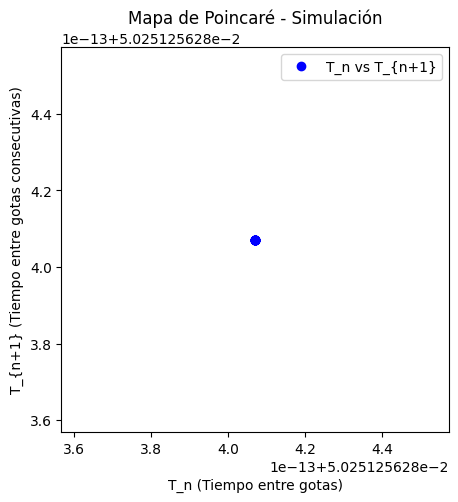

In [48]:
# Detección de eventos (momento en que la gota alcanza un umbral de caída)
threshold = 3  # ajusta según tu sistema
drop_events = sol.t[sol.y[0] < threshold]  # tiempos en los que la gota pasa el umbral

# Calculamos los periodos entre gotas consecutivas
periods = np.diff(drop_events)

# Graficar Mapa de Poincaré: T_n vs. T_{n+1}
plt.figure(figsize=(5, 5))
plt.plot(periods[:-1], periods[1:], 'bo', label='T_n vs T_{n+1}')
plt.xlabel('\nT_n (Tiempo entre gotas)')
plt.ylabel('T_{n+1} (Tiempo entre gotas consecutivas)')
plt.title('Mapa de Poincaré - Simulación')
plt.legend()
plt.show()

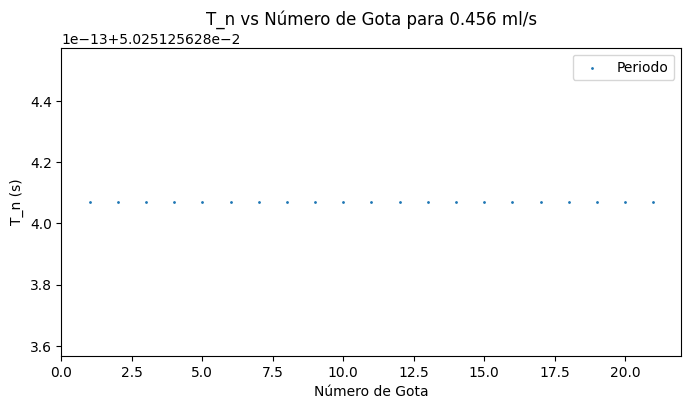

In [49]:
# Gráfica del periodo entre gotas vs el número de gota
plt.figure(figsize=(8, 4))
plt.scatter(np.arange(1, len(periods) + 1), periods, s=1, label='Periodo')
plt.xlabel('Número de Gota')
plt.ylabel('T_n (s)')
plt.title(f'T_n vs Número de Gota para {flow_rate} ml/s')
plt.legend()
plt.show()